In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
#from qp import get_stocks # 1/PBR + GP/A
#from ncav import get_stocks # NCAV
#from super_value import get_stocks
from super_quality import get_stocks

importing Jupyter notebook from super_quality.ipynb
importing Jupyter notebook from common.ipynb


In [3]:
MODEL_NAME = 'super-quality'
DATA_DIR = 'data/daily/8-1'

In [4]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [5]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv


In [6]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-08-01 data/daily/8-1/2002-08-01.csv
전체 1576
국외주식 제외 1576
증자기업 제외 1471
당기순이익 적자 제외 1025
영업활동으로인한현금흐름 적자 제외 814
가격정보 없는 기업 제외 563
선정 기업 수 30
------------------------------
2003-08-01 data/daily/8-1/2003-08-01.csv
전체 1668


common.ipynb:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "                return True\n",


국외주식 제외 1668
증자기업 제외 1571
당기순이익 적자 제외 1115
영업활동으로인한현금흐름 적자 제외 914
가격정보 없는 기업 제외 631
선정 기업 수 30
------------------------------
2004-08-02 data/daily/8-1/2004-08-02.csv
전체 1716
국외주식 제외 1716
증자기업 제외 1591
당기순이익 적자 제외 1130
영업활동으로인한현금흐름 적자 제외 942
가격정보 없는 기업 제외 649
선정 기업 수 30
------------------------------
2005-08-01 data/daily/8-1/2005-08-01.csv
전체 1812
국외주식 제외 1810
증자기업 제외 1713
당기순이익 적자 제외 1263
영업활동으로인한현금흐름 적자 제외 1047
가격정보 없는 기업 제외 699
선정 기업 수 30
------------------------------
2006-08-01 data/daily/8-1/2006-08-01.csv
전체 1861
국외주식 제외 1858
증자기업 제외 1705
당기순이익 적자 제외 1261
영업활동으로인한현금흐름 적자 제외 1050
가격정보 없는 기업 제외 716
선정 기업 수 30
------------------------------
2007-08-01 data/daily/8-1/2007-08-01.csv
전체 1952
국외주식 제외 1945
증자기업 제외 1799
당기순이익 적자 제외 1318
영업활동으로인한현금흐름 적자 제외 1080
가격정보 없는 기업 제외 741
선정 기업 수 30
------------------------------
2008-08-01 data/daily/8-1/2008-08-01.csv
전체 2046
국외주식 제외 2035
증자기업 제외 1863
당기순이익 적자 제외 1298
영업활동으로인한현금흐름 적자 제외 1029
가격정보 없는 기업 제외 720
선정 기업 수 30
--------------------------

In [7]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률을 구한다.
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) # 가격 정보가 없을 경우 상폐
                end_price = end_price.iloc[0]
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-08-01 ~ 2003-08-01 : 0.8928883023570103
2003-08-01 ~ 2004-08-02 : 0.9383932288316269
2004-08-02 ~ 2005-08-01 : 2.6765745014999336
2005-08-01 ~ 2006-08-01 : 1.1495936019312991
2006-08-01 ~ 2007-08-01 : 1.7095080520012218
2007-08-01 ~ 2008-08-01 : 0.6981281952064701
2008-08-01 ~ 2009-08-03 : 1.202632827379844
2009-08-03 ~ 2010-08-02 : 1.202183609135522
2010-08-02 ~ 2011-08-01 : 1.006268237938779
2011-08-01 ~ 2012-08-01 : 1.3650031404512444
2012-08-01 ~ 2013-08-01 : 1.3482004243136634
2013-08-01 ~ 2014-08-01 : 1.4013806091709162
2014-08-01 ~ 2015-08-03 : 1.7601388554602067
2015-08-03 ~ 2016-08-01 : 1.0845800716779705
2016-08-01 ~ 2017-08-01 : 0.8317272676088829
2017-08-01 ~ 2018-08-01 : 1.5772785383629024
2018-08-01 ~ 2019-08-01 : 0.8933740709992982


In [8]:
df_account['total'] = df_account['yield'].cumprod()

In [9]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [10]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [11]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [12]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

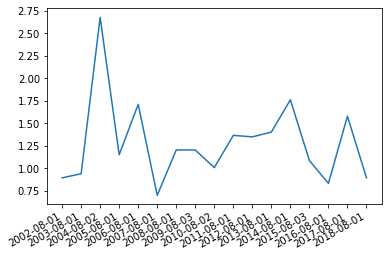

In [13]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['yield'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

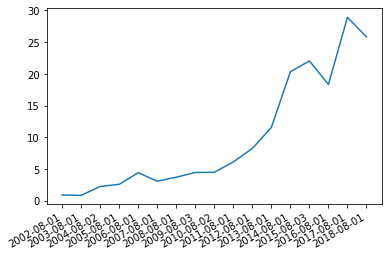

In [14]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

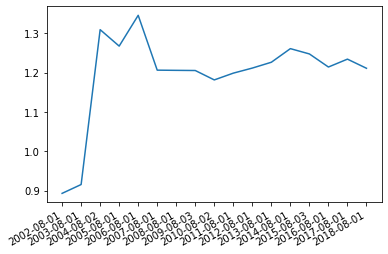

In [15]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [16]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[049720, 018310, 036800, 018680, 007370, 05381...",0.892888,"[0.5467391304347826, 1.2110091743119267, 0.123...",0.892888,0.892888,0.300000,1.953488,0.123043,056700,036800
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[024950, 018680, 065650, 012790, 060260, 06038...",0.938393,"[0.6609442060085837, 0.35661764705882354, 0.95...",0.837880,0.915358,0.233333,4.947368,0.304196,050120,052290
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[011080, 017680, 036800, 018680, 018310, 00829...",2.676575,"[3.3224043715846996, 1.826625386996904, 2.8417...",2.242649,1.308942,1.000000,12.521739,1.223958,016100,045060
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[049720, 011080, 017680, 008290, 051360, 04183...",1.149594,"[1.0982142857142858, 1.175986842105263, 1.9463...",2.578135,1.267145,0.533333,2.701493,0.124739,049470,014570
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[049720, 011080, 036120, 014100, 079940, 00829...",1.709508,"[1.146341463414634, 0.8419580419580419, 1.625,...",4.407343,1.345350,0.933333,5.027125,0.841958,085370,011080
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[049720, 024950, 036120, 060300, 032860, 08345...",0.698128,"[0.7446808510638298, 1.1713395638629283, 0.685...",3.076890,1.206013,0.166667,2.258652,0.051104,041830,010600
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[049720, 011080, 036120, 070590, 026040, 06448...",1.202633,"[0.9904761904761905, 0.6288659793814433, 0.906...",3.700369,1.205530,0.500000,3.166667,0.575461,079190,087730
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[049720, 036120, 098660, 017680, 058450, 02018...",1.202184,"[1.5096153846153846, 1.1958762886597938, 0.932...",4.448523,1.205111,0.666667,3.220513,0.604603,069510,099440
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[049720, 036120, 098660, 070300, 079970, 03334...",1.006268,"[0.9057324840764331, 0.8793103448275862, 1.468...",4.476408,1.181206,0.500000,1.882979,0.463850,018680,111820
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[049720, 098660, 131370, 011080, 069920, 01868...",1.365003,"[1.3783403656821378, 0.662771285475793, 1.0660...",6.110310,1.198412,0.666667,4.464968,0.475191,012690,096690


In [ ]:
df_account.to_csv('log/' + MODEL_NAME + '-' + os.path.basename(DATA_DIR) + '.csv', index=False)